In [37]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

In [38]:
def load_and_preprocess(dataset_path):
    data = pd.read_csv(dataset_path, sep="\t")
    scaled_data = StandardScaler().fit_transform(data)
    return scaled_data, data

In [39]:
def eval_kmeans(data, dataset_name, max_k=10):
    inertias = []
    silhouettes = []
    best_metrics = {"silhouette": -1, "dbi": np.inf, "k": None}

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(data)

        if len(np.unique(labels)) > 1:
            silhouette = silhouette_score(data, labels)
            dbi = davies_bouldin_score(data, labels)
            inertias.append(kmeans.inertia_)
            silhouettes.append(silhouette)

            if silhouette > best_metrics["silhouette"]:
                best_metrics.update({"silhouette": silhouette, "dbi": dbi, "k": k})

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_k + 1), inertias, marker="o")
    plt.title(f"{dataset_name} - Elbow Method")

    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_k + 1), silhouettes, marker="o")
    plt.title(f"{dataset_name} - Silhouette Score")

    plt.show()

    return best_metrics

In [41]:
def eval_dbscan(data, dataset_name, eps_range=np.arange(0.1, 1.0, 0.1), min_samples=5):
    best_metrics = {"silhouette": -1, "dbi": np.inf, "eps": None}

    for eps in eps_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(data)

        if len(np.unique(labels)) > 1:
            silhouette = silhouette_score(data, labels)
            dbi = davies_bouldin_score(data, labels)

            if silhouette > best_metrics["silhouette"]:
                best_metrics.update({"silhouette": silhouette, "dbi": dbi, "eps": eps})

    return best_metrics

In [42]:
def eval_hierarchical(data, dataset_name, max_k=10):
    best_metrics = {"silhouette": -1, "dbi": np.inf, "k": None}

    Z = linkage(data, method="ward")
    plt.figure(figsize=(10, 5))
    dendrogram(Z)
    plt.title(f"{dataset_name} - Dendrogram")
    plt.show()

    for k in range(2, max_k + 1):
        agg = AgglomerativeClustering(n_clusters=k)
        labels = agg.fit_predict(data)

        if len(np.unique(labels)) > 1:
            silhouette = silhouette_score(data, labels)
            dbi = davies_bouldin_score(data, labels)

            if silhouette > best_metrics["silhouette"]:
                best_metrics.update({"silhouette": silhouette, "dbi": dbi, "k": k})

    return best_metrics

In [45]:
def eval_all_methods(dataset_path, dataset_name):
    data, raw_data = load_and_preprocess(dataset_path)

    results = {
        "K-means": eval_kmeans(data, dataset_name),
        "DBSCAN": eval_dbscan(data, dataset_name),
        "Hierarchical": eval_hierarchical(data, dataset_name),
    }

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    best_k = results["K-means"]["k"]
    kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data)
    axes[0].scatter(raw_data.iloc[:, 0], raw_data.iloc[:, 1], c=labels, cmap="viridis")
    axes[0].set_title("K-means Clusters")

    best_eps = results["DBSCAN"]["eps"]
    dbscan = DBSCAN(eps=best_eps, min_samples=5)
    labels = dbscan.fit_predict(data)
    axes[1].scatter(raw_data.iloc[:, 0], raw_data.iloc[:, 1], c=labels, cmap="viridis")
    axes[1].set_title("DBSCAN Clusters")

    best_k = results["Hierarchical"]["k"]
    agg = AgglomerativeClustering(n_clusters=best_k)
    labels = agg.fit_predict(data)
    axes[2].scatter(raw_data.iloc[:, 0], raw_data.iloc[:, 1], c=labels, cmap="viridis")
    axes[2].set_title("Hierarchical Clusters")

    plt.suptitle(dataset_name)
    plt.show()

    return results

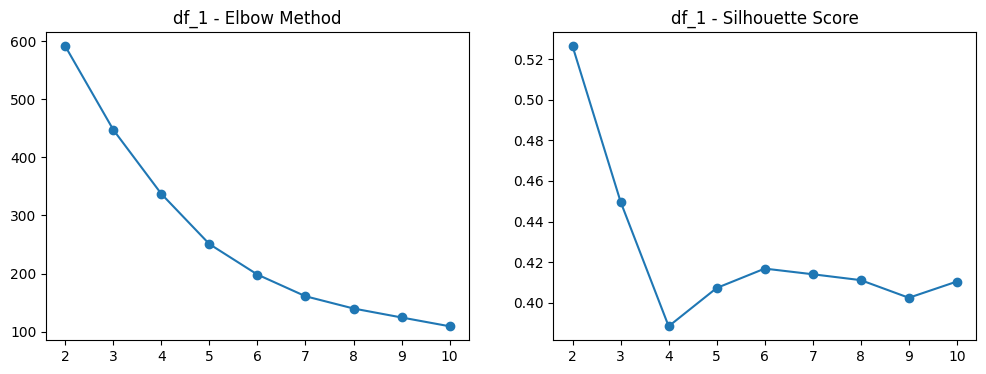

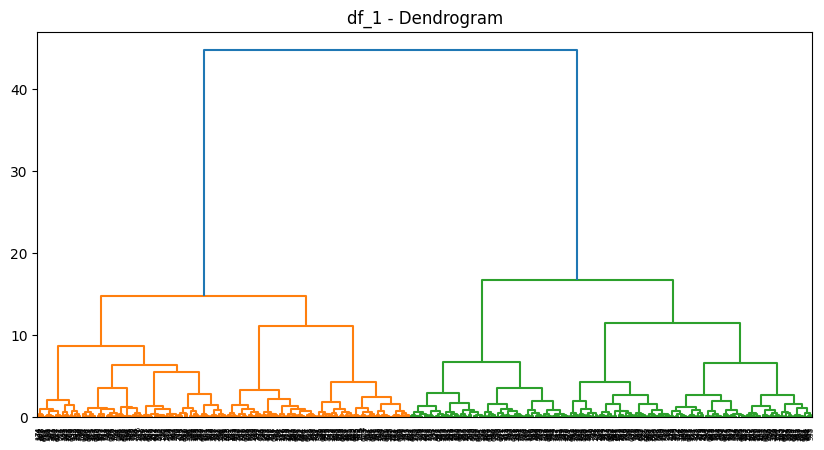

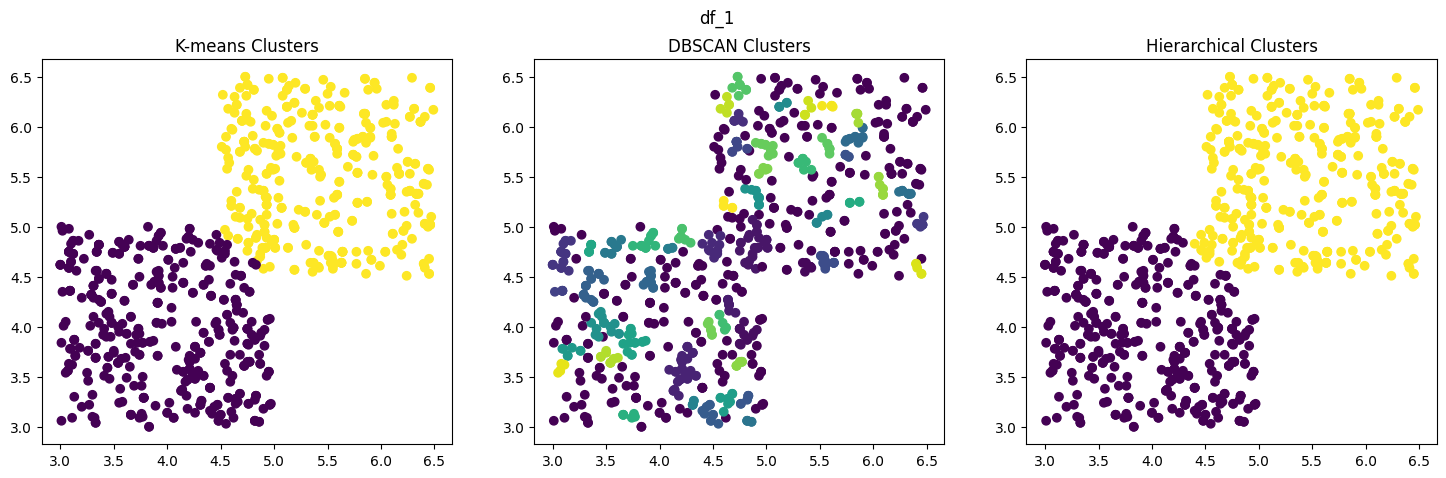


Результаты для df_1:
              silhouette       dbi    k  eps
K-means         0.526371  0.722443  2.0  NaN
DBSCAN          0.017069  2.014064  NaN  0.1
Hierarchical    0.522312  0.728314  2.0  NaN


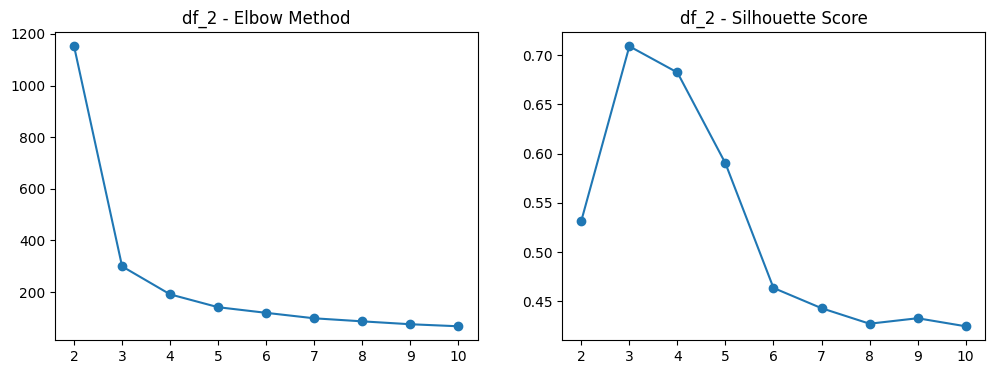

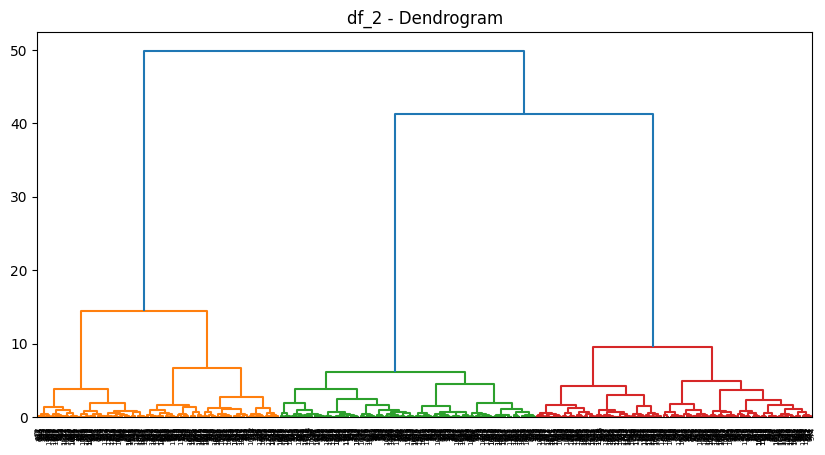

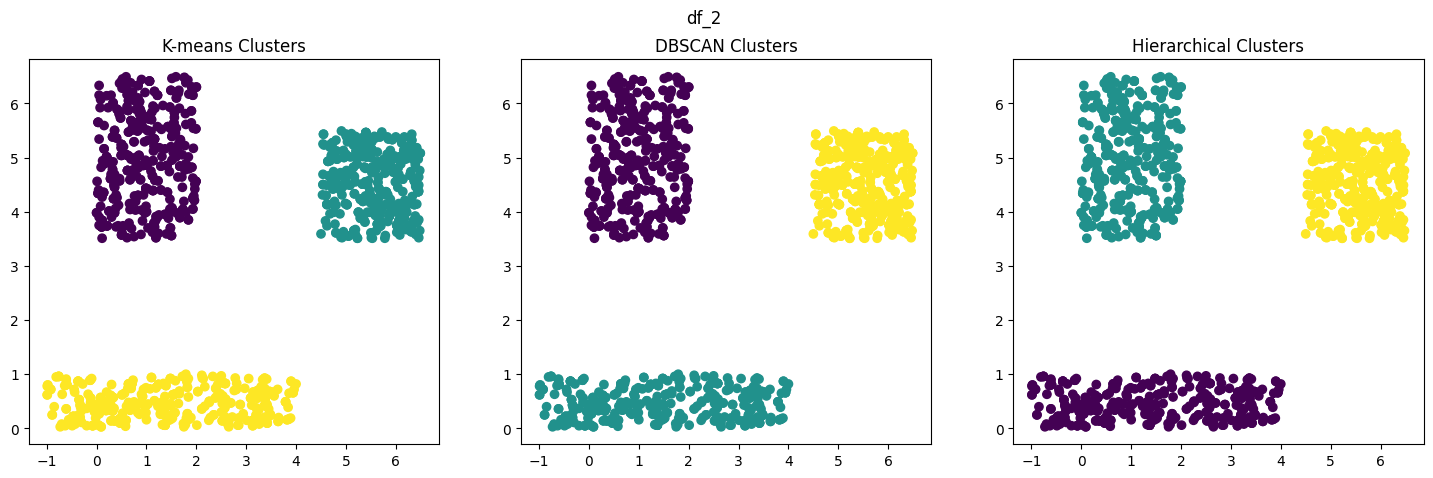


Результаты для df_2:
              silhouette       dbi    k  eps
K-means         0.709029  0.434329  3.0  NaN
DBSCAN          0.709029  0.434329  NaN  0.2
Hierarchical    0.709029  0.434329  3.0  NaN


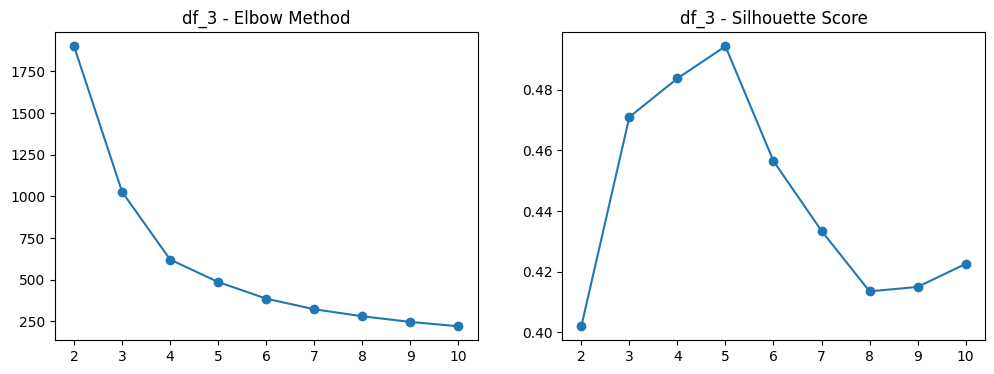

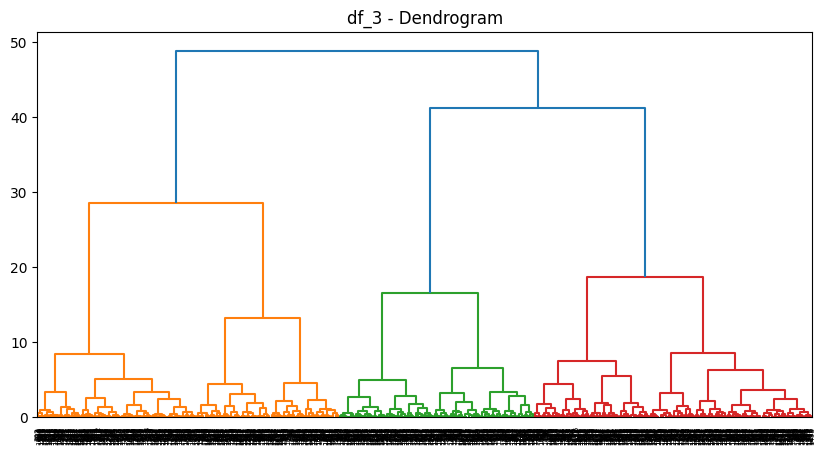

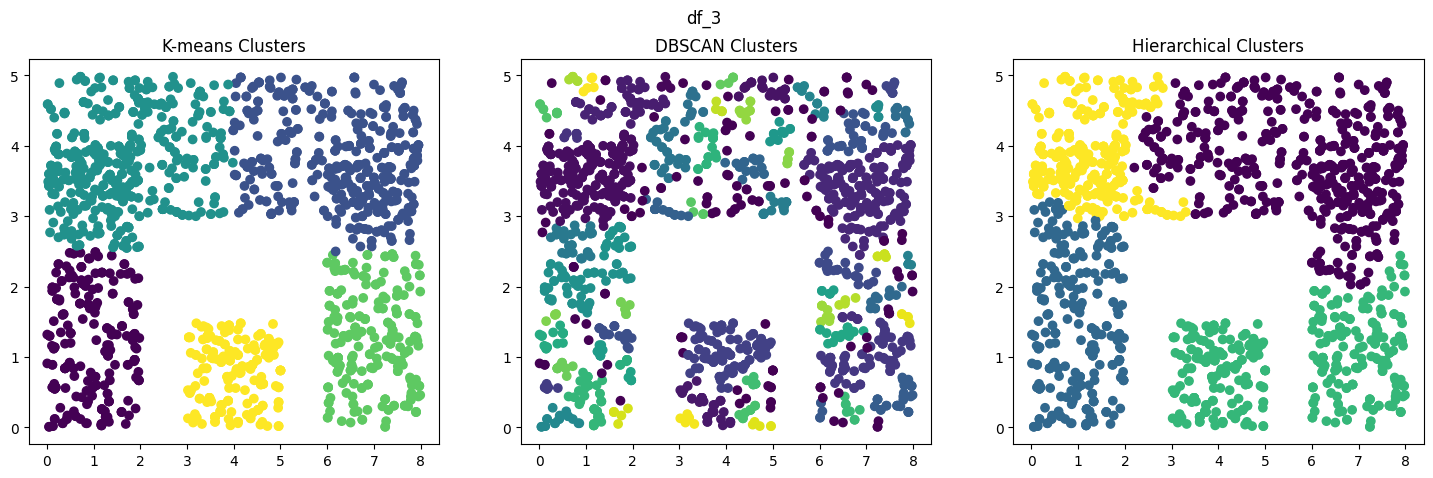


Результаты для df_3:
              silhouette       dbi    k  eps
K-means         0.494287  0.654341  5.0  NaN
DBSCAN          0.143822  1.091307  NaN  0.1
Hierarchical    0.431801  0.699994  4.0  NaN
CPU times: user 57 s, sys: 207 ms, total: 57.2 s
Wall time: 20.3 s


In [47]:
%%time

datasets = {
    "df_1": "../data/clustering/clustering_1.csv",
    "df_2": "../data/clustering/clustering_2.csv",
    "df_3": "../data/clustering/clustering_3.csv",
}

final_results = {}
for name, path in datasets.items():
    final_results[name] = eval_all_methods(path, name)
    print(f"\nРезультаты для {name}:")
    print(pd.DataFrame(final_results[name]).T)